# Notebook setup

In [1]:
# various pandas, numpy
import pandas as pd
import numpy as np
import pandas.io.data as web
from datetime import datetime
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import matplotlib.mlab as mlab
# plotting

import matplotlib.pyplot as plt

# make plots inline
%matplotlib inline

# formatting options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 82) 
pd.set_option('precision', 7)

/usr/local/lib/python2.7/dist-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Modelling of a portfolio with Python and pandas

In [2]:
def create_portfolio(tickers, weights=None):
    if weights is None: 
        shares = np.ones(len(tickers))/len(tickers)
    portfolio = pd.DataFrame({'Tickers': tickers, 
                              'Weights': weights}, 
                             index=tickers)
    return portfolio

In [3]:
portfolio = create_portfolio(['Stock A', 'Stock B'], [1, 1])
portfolio

         Tickers  Weights
Stock A  Stock A        1
Stock B  Stock B        1

In [4]:
returns = pd.DataFrame(
        {'Stock A': [0.1, 0.24, 0.05, -0.02, 0.2],
         'Stock B': [-0.15, -0.2, -0.01, 0.04, -0.15]})
returns

   Stock A  Stock B
0     0.10    -0.15
1     0.24    -0.20
2     0.05    -0.01
3    -0.02     0.04
4     0.20    -0.15

In [5]:
def calculate_weighted_portfolio_value(portfolio, 
                                       returns, 
                                       name='Value'):
    total_weights = portfolio.Weights.sum()
    weighted_returns = returns * (portfolio.Weights / 
                                  total_weights)
    return pd.DataFrame({name: weighted_returns.sum(axis=1)})

In [6]:
wr = calculate_weighted_portfolio_value(portfolio, 
                                        returns, 
                                        "Value")
with_value = pd.concat([returns, wr], axis=1)
with_value

   Stock A  Stock B  Value
0     0.10    -0.15 -0.025
1     0.24    -0.20  0.020
2     0.05    -0.01  0.020
3    -0.02     0.04  0.010
4     0.20    -0.15  0.025

In [7]:
with_value.std()

Stock A    0.1066771
Stock B    0.1031019
Value      0.0203101
dtype: float64

In [8]:
def plot_portfolio_returns(returns, title=None):
    returns.plot(figsize=(12,8))
    plt.xlabel('Year')
    plt.ylabel('Returns')
    if title is not None: plt.title(title)
    plt.show()
    plt.savefig('5104OS_09_02.png', dpi=300)

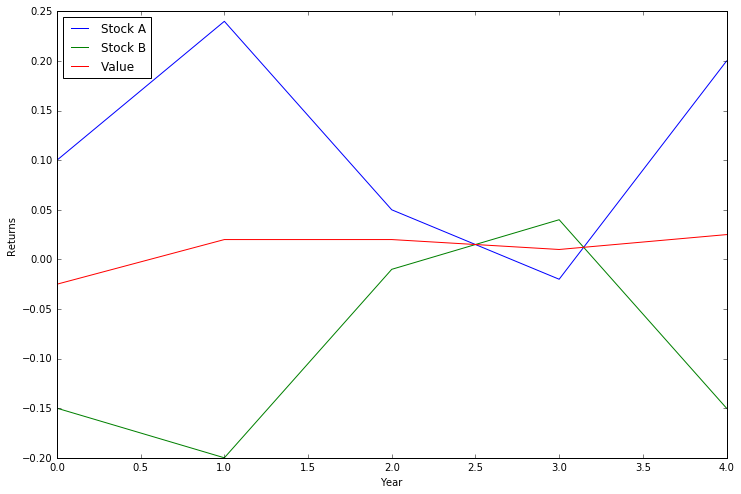

In [9]:
plot_portfolio_returns(with_value)

In [10]:
returns.corr()

           Stock A    Stock B
Stock A  1.0000000 -0.9255716
Stock B -0.9255716  1.0000000

# Computing an Efficient Portfolio

## Gathering historical returns from Yahoo! Finance

In [11]:
def get_historical_closes(ticker, start_date, end_date):
    # get the data for the tickers.  This will be a panel
    p = web.DataReader(ticker, "yahoo", start_date, end_date)    
    # convert the panel to a DataFrame and selection only Adj Close
    # while making all index levels columns
    d = p.to_frame()['Adj Close'].reset_index()
    # rename the columns
    d.rename(columns={'minor': 'Ticker', 
                      'Adj Close': 'Close'}, inplace=True)
    # pivot each ticker to a column
    pivoted = d.pivot(index='Date', columns='Ticker')
    # and drop the one level on the columns
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

In [12]:
closes = get_historical_closes(['MSFT', 'AAPL', 'KO'], '2010-01-01', '2014-12-31')

In [13]:
closes[:5]

Ticker           AAPL         KO       MSFT
Date                                       
2010-01-04  27.847252  23.318762  25.884104
2010-01-05  27.895396  23.036679  25.892466
2010-01-06  27.451683  23.028504  25.733566
2010-01-07  27.400936  22.971269  25.465944
2010-01-08  27.583106  22.546103  25.641571

In [14]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))

In [15]:
# calculate daily returns
daily_returns = calc_daily_returns(closes)
daily_returns[:5]

Ticker           AAPL         KO       MSFT
Date                                       
2010-01-04        NaN        NaN        NaN
2010-01-05  0.0017274 -0.0121706  0.0003230
2010-01-06 -0.0160342 -0.0003549 -0.0061558
2010-01-07 -0.0018503 -0.0024885 -0.0104542
2010-01-08  0.0066263 -0.0186820  0.0068729

In [16]:
# calculate annual returns
def calc_annual_returns(daily_returns):
    grouped = np.exp(daily_returns.groupby(
        lambda date: date.year).sum())-1
    return grouped

In [17]:
annual_returns = calc_annual_returns(daily_returns)
annual_returns

Ticker       AAPL         KO       MSFT
2010    0.5072193  0.1893663 -0.0794414
2011    0.2555803  0.0945863 -0.0451566
2012    0.3256690  0.0652759  0.0579886
2013    0.0806948  0.1723302  0.4429798
2014    0.4062250  0.0526609  0.2756461

## Weighted variance co-variance calculation

In [18]:
def calc_portfolio_var(returns, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    sigma = np.cov(returns.T,ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var

In [19]:
# calculate our portfolio variance (equal weighted)
calc_portfolio_var(annual_returns)

0.0028795407955846965

## The Sharpe Ratio

In [20]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    # get the portfolio variance
    var = calc_portfolio_var(returns, weights)
    # and the means of the stocks in the portfolio
    means = returns.mean()
    # and return the sharpe ratio
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)

In [21]:
# calculate equal weighted sharpe ratio
sharpe_ratio(annual_returns)

3.2010928229213982

## Optimization and minimization

In [22]:
# function to minimize
def y_f(x): return 2+x**2

In [23]:
scopt.fmin(y_f, 1000)

Optimization terminated successfully.
         Current function value: 2.000000
         Iterations: 27
         Function evaluations: 54


array([ 0.])

## Constructing an optimal portfolio 

In [24]:
def negative_sharpe_ratio_n_minus_1_stock(weights, 
                                          returns, 
                                          risk_free_rate):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1-np.sum(weights))
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [25]:
def optimize_portfolio(returns, risk_free_rate):
    """ 
    Performs the optimization
    """
    # start with equal weights
    w0 = np.ones(returns.columns.size-1, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, 
                    w0, args=(returns, risk_free_rate))
    # build final set of weights
    final_w = sp.append(w1, 1 - np.sum(w1))
    # and calculate the final, optimized, sharpe ratio
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    return (final_w, final_sharpe)

In [26]:
# optimize our portfolio
optimize_portfolio(annual_returns, 0.0003)

Optimization terminated successfully.
         Current function value: -7.829861
         Iterations: 46
         Function evaluations: 89


(array([ 0.76353353,  0.2103234 ,  0.02614307]), 7.8298611572216874)

# Visualizing the Efficient Frontier

In [27]:
def objfun(W, R, target_ret):
    stock_mean = np.mean(R,axis=0)
    port_mean = np.dot(W,stock_mean) # portfolio mean
    cov=np.cov(R.T) # var-cov matrix
    port_var = np.dot(np.dot(W,cov),W.T) # portfolio variance
    penalty = 2000*abs(port_mean-target_ret)# penalty 4 deviation
    return np.sqrt(port_var) + penalty # objective function

In [28]:
def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    
    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks)/nstocks
        bounds = [(0,1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1})
        results = scopt.minimize(objfun, weights, (returns, r), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
        if not results.success: # handle error
            raise Exception(result.message)
        result_means.append(np.round(r,4)) # 4 decimal places
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        result_stds.append(std_)
        
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}

In [29]:
# calculate our frontier
frontier_data = calc_efficient_frontier(annual_returns)

In [30]:
# first five risk levels
frontier_data['Stds'][:5]

[0.055842999999999997, 0.053446, 0.052564, 0.051706000000000002, 0.050871]

In [31]:
# first five mean returns
frontier_data['Means'][:5]

[0.1148, 0.1169, 0.11890000000000001, 0.12089999999999999, 0.1229]

In [32]:
# first five sets of optimal weights
frontier_data['Weights'][:5]

[array([ 0.,  1.,  0.]),
 array([ 0.00512,  0.9308 ,  0.06407]),
 array([ 0.01497,  0.9177 ,  0.06733]),
 array([ 0.02469,  0.90303,  0.07228]),
 array([ 0.03458,  0.89049,  0.07493])]

In [33]:
def plot_efficient_frontier(frontier_data):
    plt.figure(figsize=(12,8))
    plt.title('Efficient Frontier')
    plt.xlabel('Standard Deviation of the porfolio (Risk))')
    plt.ylabel('Return of the portfolio')
    plt.plot(frontier_data['Stds'], frontier_data['Means'], '--'); 
    plt.savefig('5104OS_09_20.png', bbox_inches='tight', dpi=300)

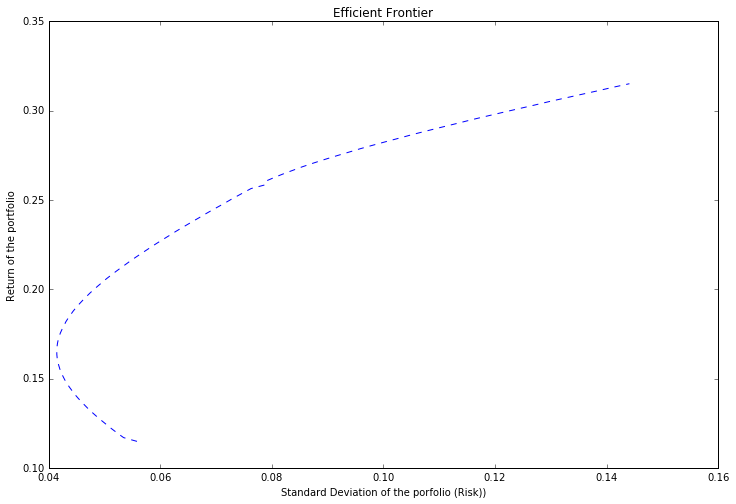

In [34]:
plot_efficient_frontier(frontier_data)

# Value At Risk

In [35]:
# get adjusted close values for AAPL in 2014
aapl_closes = get_historical_closes(['AAPL'], 
                                    datetime(2014, 1, 1),
                                    datetime(2014, 12, 31))
aapl_closes[:5]

Ticker           AAPL
Date                 
2014-01-02  74.437252
2014-01-03  72.802175
2014-01-06  73.199166
2014-01-07  72.675675
2014-01-08  73.135920

In [36]:
# now convert the daily prices to returns
returns = calc_daily_returns(aapl_closes)
returns[:5]

Ticker           AAPL
Date                 
2014-01-02        NaN
2014-01-03 -0.0222107
2014-01-06  0.0054382
2014-01-07 -0.0071773
2014-01-08  0.0063129

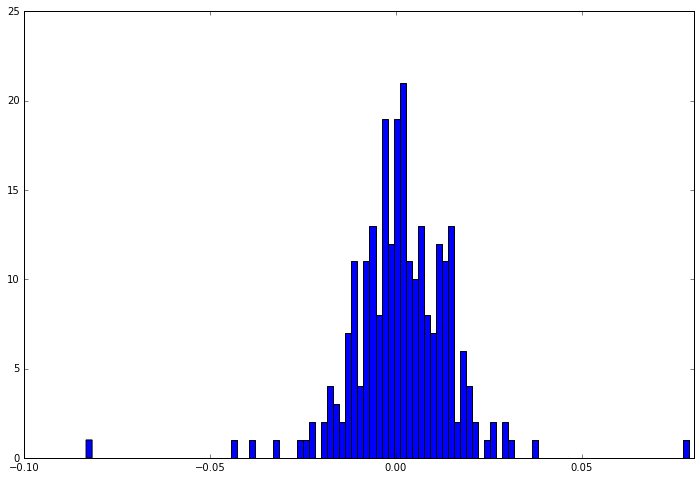

In [37]:
# plot the histogram of returns
plt.figure(figsize=(12,8))
plt.hist(returns.values[1:], bins=100);
plt.savefig('5104OS_09_23.png', bbox_inches='tight', dpi=300)

In [38]:
# get the z-score for 95%
z = spstats.norm.ppf(0.95)
z

1.6448536269514722

In [39]:
# our position is 1000 shares of AAPL at the price
# on 2014-22-31
position = 1000 * aapl_closes.ix['2014-12-31'].AAPL
position

106168.64999999999

In [40]:
# what is our VaR
VaR = position * (z * returns.AAPL.std())
VaR

2382.2481562023554

# Misc

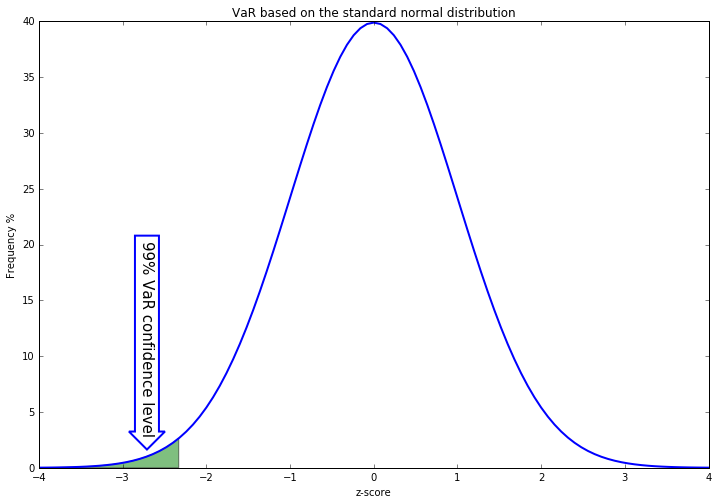

In [41]:
# draw a 99% one-tail confidence interval
x = np.linspace(-4,4,101)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
x2 = np.linspace(-4,-2.33,101)
y2 = np.exp(-x2**2/2) / np.sqrt(2*np.pi)
f = plt.figure(figsize=(12,8))
plt.plot(x,y*100, linewidth=2)
xf, yf = mlab.poly_between(x2, 0*x2, y2*100)
plt.fill(xf, yf, facecolor='g', alpha=0.5)
plt.gca().set_xlabel('z-score')
plt.gca().set_ylabel('Frequency %')
plt.title("VaR based on the standard normal distribution")
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="w", ec="b", lw=2)
t = f.text(0.25, 0.35, "99% VaR confidence level", ha="center", va="center", 
           rotation=270,
            size=15,
            bbox=bbox_props)
plt.savefig('5104OS_09_21.png', bbox_inches='tight', dpi=300)